In [1]:
# import packages
import numpy as np
from scipy import stats

from share_code.utils import plt, sns, my_saving_display, pinball

import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.regression.quantile_regression import QuantReg



sns.set_palette("colorblind")

/home/jo/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# to get images in the notebook
%matplotlib inline 

In [3]:
dirname = "../prebuiltimages/"
imageformat = ".pdf"  # should be .pdf or .png    
# some colors I'll use
brown = (0.64, 0.16, 0.16)
purple = (148. / 255, 0, 211. / 255)
plt.close("all")
saving = True  # True

In [4]:
# import seaborn as sns
# sns.set_palette("colorblind")
# sns.set_style("ticks")
color_blind_list = sns.color_palette("colorblind", 8)
c0 = color_blind_list[0]
c1 = color_blind_list[1]
c2 = color_blind_list[2]
c3 = color_blind_list[3]

In [5]:
x = np.linspace(-4, 4, 500)


def quantile_loss(x, threshold=0.95):
    return pinball(x, slope1=threshold - 1, slope2=threshold)


def plot_data_statistics(x, function, threshold, figname, ylims=[-1, 5], xlims=[-4, 4], derivate=False,
                         name=r'$\ell_\alpha$,'):

    fig1, ax = plt.subplots(figsize=(5, 5))
    if derivate is False:
        ax.plot(x, np.abs(x) / 2, 'k--', lw=2, label=r'$\frac{|\cdot|}{2}$')
    ax.set_xlim(xlims[0], xlims[1])
    ax.set_ylim(ylims[0], ylims[1])
    ax.plot(x, function(x, threshold), c=c0, lw=1.7,
            label=name + r' $\alpha= {:.2f}$'.format(threshold))

    plt.legend(loc='upper center')
    plt.tight_layout()
    plt.show()

    if saving:
        my_saving_display(fig1, dirname, figname, imageformat, saving=saving)

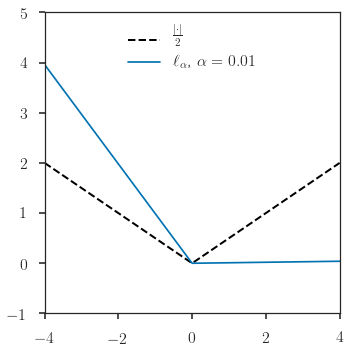

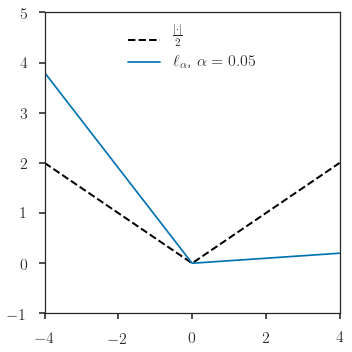

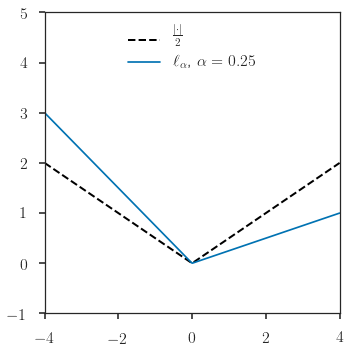

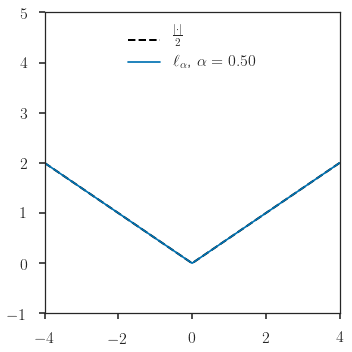

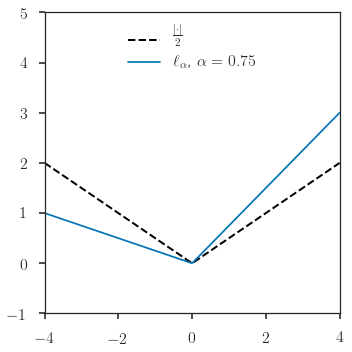

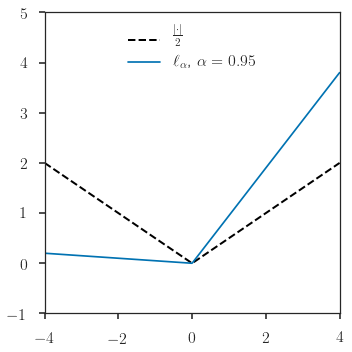

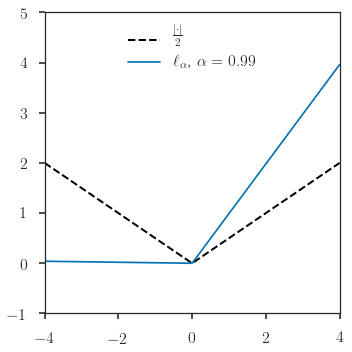

In [6]:
quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]

for q in quantiles:
    plot_data_statistics(x, quantile_loss, q, "quantile_%d" % (100 * q))

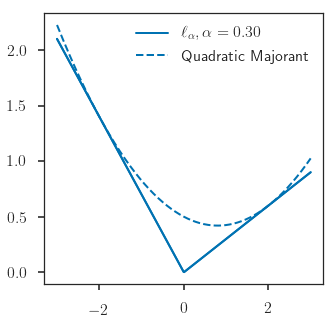

In [7]:
q = 0.3
x = np.linspace(-3, 3, 500)
pin = np.maximum(q * x, (q - 1) * x)
fig_MM = plt.figure(figsize=(5, 5))
plt.plot(x, pin,c=c0, lw=2)
x0 = 2
plt.plot(x, pin,c=c0, lw=2, label=r'$\ell_\alpha, \alpha= {:.2f}$'.format(q))
if x0 > 0:
    plt.plot(x,  1. / (4. * x0) * (x - x0) ** 2 + q * x, '--', c=c0, lw=2,
             label='Quadratic Majorant')
plt.legend()
plt.show()
my_saving_display(fig_MM, dirname, 'quad_MM', imageformat, saving=saving)

# Example from the Statsmodel:

In [8]:
# Extracted from the statsmodel example
# http://www.statsmodels.org/stable/examples/notebooks/generated/quantile_regression.html
data = sm.datasets.engel.load_pandas().data
data.head()


,income,foodexp
0,420.157651,255.839425
1,541.411707,310.958667
2,901.157457,485.680014
3,639.080229,402.997356
4,750.875606,495.560775


In [9]:
mod = smf.quantreg('foodexp ~ income', data)
quantiles = np.arange(.05, .96, .1)
quantiles=np.append(quantiles,0.5) # adding the LAD estimator at the last position
def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['income']] + \
            res.conf_int().loc['income'].tolist()
    
models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b','lb','ub'])

ols = smf.ols('foodexp ~ income', data).fit()
ols_ci = ols.conf_int().loc['income'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['income'],
           lb = ols_ci[0],
           ub = ols_ci[1])

print(models)
print(ols)



       q           a         b        lb        ub
0   0.05  124.880099  0.343361  0.268632  0.418090
1   0.15  111.693660  0.423708  0.382780  0.464636
2   0.25   95.483539  0.474103  0.439900  0.508306
3   0.35  105.841294  0.488901  0.457759  0.520043
4   0.45   81.083647  0.552428  0.525021  0.579835
5   0.55   89.661370  0.565601  0.540955  0.590247
6   0.65   74.033433  0.604576  0.582169  0.626982
7   0.75   62.396584  0.644014  0.622411  0.665617
8   0.85   52.272216  0.677603  0.657383  0.697823
9   0.95   64.103964  0.709069  0.687831  0.730306
10  0.50   81.482256  0.560181  0.534222  0.586139
{'a': 147.47538852370573, 'b': 0.48517842367692354, 'lb': 0.4568738130184233, 'ub': 0.5134830343354237}


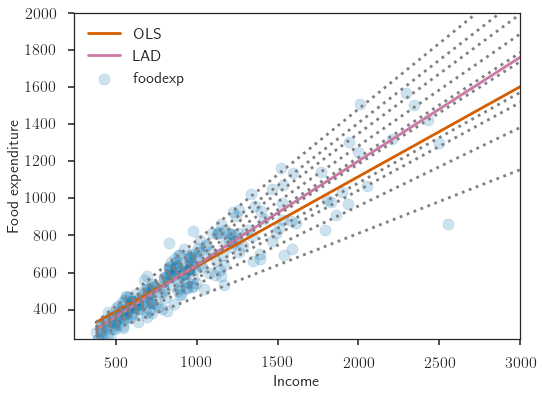

In [10]:
x = np.arange(data.income.min(), data.income.max(), 50)
get_y = lambda a, b: a + b * x
nb_quantiles = models.shape[0]-1
fig, ax = plt.subplots(figsize=(8, 6))

ax.set_xlim((240, 3000))
ax.set_ylim((240, 2000))
ax.set_xlabel('Income', fontsize=16)
ax.set_ylabel('Food expenditure', fontsize=16);
ax.scatter(data.income, data.foodexp, alpha=.2)
my_saving_display(fig, dirname, "quantile_regression_raw", imageformat,saving=saving)


y = get_y(ols['a'], ols['b'])
ax.plot(x, y, color=color_blind_list[2], label='OLS')

y = get_y(models.a[nb_quantiles], models.b[nb_quantiles])
ax.plot(x, y, color=color_blind_list[3], label='LAD')
legend = ax.legend()

my_saving_display(fig, dirname, "quantile_regression_OLS_LAD", imageformat,saving=saving)

for i in range(nb_quantiles):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', color='grey')


my_saving_display(fig, dirname, "quantile_regression", imageformat,saving=saving)


# Robustness to $y$ outliers

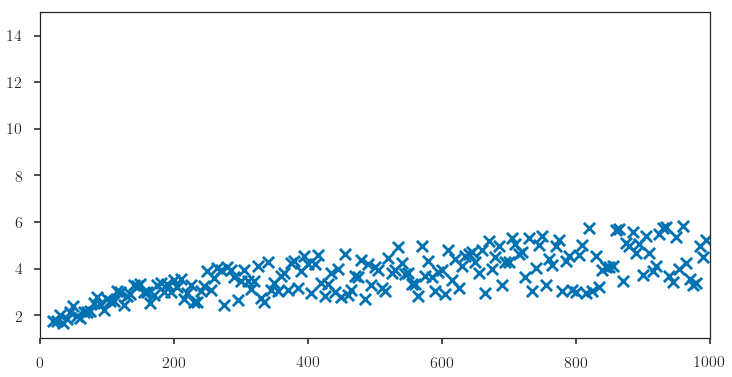

In [11]:
# simple data
np.random.seed(24)
x = np.arange(20, 1000, 5)
y = np.log10(x) + np.sqrt(x) / 10. * np.random.rand(len(x))
fig1 = plt.figure(figsize=(12, 6))
plt.xlim(0, 1000)
plt.ylim(1,15)
plt.scatter(x, y, marker='x')
my_saving_display(fig1, dirname, "quantile_data", imageformat,saving=saving)

In [12]:
df = pd.DataFrame(np.vstack([y, x, np.log10(x)]).T, 
                  columns=['y', 'x', 'log10x'])
df.head()

,y,x,log10x
0,1.730363,20.0,1.301030
1,1.747696,25.0,1.397940
2,2.024771,30.0,1.477121
3,1.674262,35.0,1.544068
4,1.830412,40.0,1.602060


In [13]:
def predict_log_example(df, model):
    return model["intercept"] + df['x'] * model["x"] + np.log10(df['x']) * model["log10x"]


def fit_log_example(df, quantiles, title, plot=True):
    mod = smf.quantreg('y ~ x + log10x', df)

    def fit_model(q):
        res = mod.fit(q=q)
        return [q, res.params['Intercept'], res.params['x']] + \
               [res.params['log10x']]

    models = [fit_model(q) for q in quantiles]
    models = pd.DataFrame(models, columns=['q', 'intercept', 'x', 'log10x'])
    models.set_index('q', inplace=True)

    if plot:
        fig_qt = plt.figure(figsize=(12, 6))
        for q in quantiles:
            plt.plot(x, predict_log_example(df, models.loc[q]),
                     label=r'$q = {0}\%$'.format(int(100 * q)))
        plt.scatter(df['x'], df['y'], marker='x')
    plt.xlim(0, 1000)
    plt.ylim(1,15)
    plt.legend()
    plt.show()
    my_saving_display(fig_qt, dirname, title, imageformat, saving=saving)
    return models

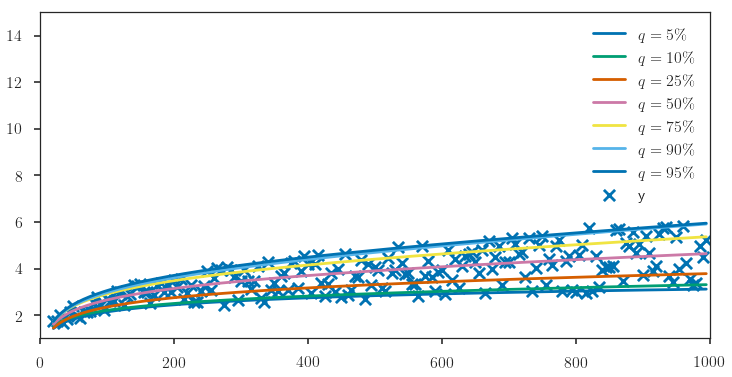

In [14]:
quantiles = [0.05, 0.10, 0.25, 0.5, 0.75, 0.90, 0.95]

models = fit_log_example(df, quantiles,"quantile_normal_case")

In [15]:
# randomly corrupt the data above the 0.95 quantile
df_outliers = df.copy()
last_quantile = y > predict_log_example(df_outliers, models.loc[0.95])
df_outliers.loc[last_quantile, 'y'] += 5 + np.random.rand(last_quantile.sum())


/home/jo/anaconda3/lib/python3.6/site-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


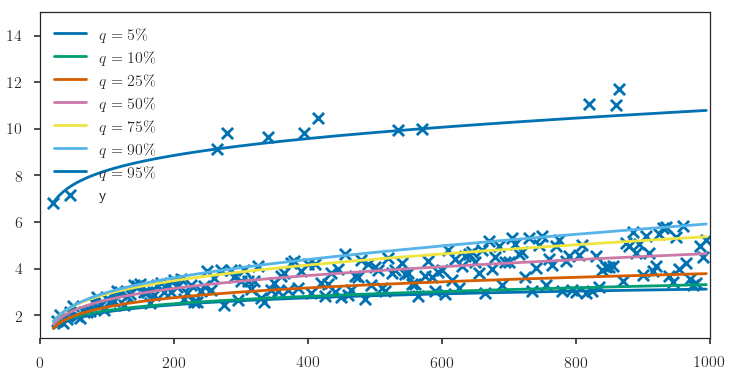

In [16]:
models_outliers = fit_log_example(df_outliers, quantiles,"quantile_outlier_case")

In [17]:
pd.options.display.float_format = '{:,.4f}'.format
models["outlier"] = False
models_outliers["outlier"] = True

res = pd.concat([models, models_outliers])
res.set_index([res.index, 'outlier'], inplace=True)
res.sort_index(inplace=True)
res  # see how only the 0.95 quantile values are strongly impacted

intercept       x  log10x
q      outlier                           
0.0500 False       0.0880 -0.0001  1.0286
       True        0.0880 -0.0001  1.0286
0.1000 False       0.3685  0.0002  0.9070
       True        0.4056  0.0003  0.8829
0.2500 False      -0.2155  0.0002  1.2725
       True       -0.2155  0.0002  1.2725
0.5000 False      -0.2587  0.0006  1.4240
       True       -0.2587  0.0006  1.4240
0.7500 False      -0.3329  0.0010  1.5706
       True       -0.3045  0.0010  1.5564
0.9000 False      -0.4019  0.0015  1.6127
       True       -0.4019  0.0015  1.6127
0.9500 False      -0.5639  0.0013  1.7436
       True        4.3673  0.0008  1.8829